In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
from collections import namedtuple, defaultdict
import itertools
from operator import attrgetter
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel, LanguageModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID
from ngram import NGramModel
from train import _setup_parser

from math import exp

figsize = (12, 12)
sns.set_theme(
    rc={
        'figure.figsize': figsize,
        'axes.grid': True,
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'font.family': 'monospace',
        'font.size': 10,
    }
)

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
"""All data are stored in dicts of form {key: value}, where key is a Key and value is a SumData, or {key: values} where values is a list of SumData.
We call each pair tuple of (key, value) an item, so item[0] gets its key and item[1] gets its values.
"""

class SumData(namedtuple('SumDataTuple', ['cnt', 'loss', 'vector', 'embedding'])):
    """data structure to aggregate count, loss, vector, embedding
    """
    @property
    def mean_vector(self):
        return self.vector / np.expand_dims(self.cnt, -1)

    @property
    def mean_loss(self):
        return self.loss / self.cnt

    @property
    def ppl(self):
        return exp(self.mean_loss)

    def __add__(self, b):
        return SumData(
            cnt = self.cnt + b.cnt,
            loss = self.loss + b.loss,
            vector = self.vector + b.vector,
            embedding = self.embedding,
        )

    def __sub__(self, b):
        return SumData(
            cnt = self.cnt - b.cnt,
            loss = self.loss - b.loss,
            vector = self.vector - b.vector,
            embedding = self.embedding,
        )

    def to_numpy(self):
        return SumData(
            cnt = self.cnt,
            loss = self.loss,
            vector = self.vector.cpu().numpy(),
            embedding = self.embedding.cpu().numpy() if self.embedding else self.embedding
        )

def zero_sum_data(hidden_dim, shape=()):
    return SumData(
        cnt = np.zeros(shape, dtype=int),
        loss = np.zeros(shape),
        vector = np.zeros(shape + (hidden_dim,)),
        embedding = None,
    )

def zero_sum_data_like(sum_data):
    return zero_sum_data(sum_data.vector.shape[-1], shape=sum_data.cnt.shape)

def zero_sum_datas_like(sum_datas):
    return [zero_sum_data_like(sum_data) for sum_data in sum_datas]

def list_add(a, b):
    return [x + y for x, y in zip(a, b)]

def list_sub(a, b):
    return [x - y for x, y in zip(a, b)]


class Key(namedtuple('Key', ['token_id', 'pos'])):
    """
    token_id: token index
    pos: pos tag
    """

    @property
    def word(self):
        return idx2word[self.token_id]

    @property
    def prefix_str(self):
        return f'{self.word:<10} {self.pos:<4}' if self.token_id >= 0 else f'{self.pos:<15}'

def prefix_str(key, values):
    return f'{key.prefix_str:<15} {values[0].cnt:>6}'

def ppl_str(key, values):
    return f'{prefix_str(key, values):<22}: ' + ' '.join(f'{value.ppl:9.3f}' for value in values)

In [4]:
# printing utilities

def print_perplexities(items, print_keys):
    """
    items: dict of format {key: values}
    print_indices: token indices to print
    """

    # check consistency in cnt
    for values in items.values():
        for value in values:
            assert value.cnt == values[0].cnt

    for key in print_keys:
        values = items[key]
        print(ppl_str(key, values))

    print()

    tot_values = zero_sum_datas_like(next(iter(items.values())))

    for key, values in filter(lambda item: item[0].token_id != PAD_TOKEN_ID, items.items()):
        tot_values = list_add(tot_values, values)
    print(ppl_str(Key(-1, 'ppl'), tot_values))

    for key, values in filter(lambda item: item[0].token_id == SOS_TOKEN_ID, items.items()):
        tot_values = list_sub(tot_values, values)
    print(ppl_str(Key(-1, 'ppl_wo_sos'), tot_values))

    for key, values in filter(lambda item: item[0].token_id == EOS_TOKEN_ID, items.items()):
        tot_values = list_sub(tot_values, values)
    print(ppl_str(Key(-1, 'ppl_wo_sos_eos'), tot_values))

    print()

In [5]:
# concreteness/other measures related


# copied from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
from nltk.corpus import wordnet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(word, pos):
    wordnet_pos = get_wordnet_pos(pos)
    if not wordnet_pos:
        wordnet_pos = wordnet.NOUN  # default
    return lemmatizer.lemmatize(word, pos=wordnet_pos)


class WordRatings:
    """Maintaining ratings of words."""
    def __init__(self, excel_path, word_field='Word', **kwargs):
        """Read data from excel_path."""
        self.data = pd.read_excel(excel_path, **kwargs)
        self.data.info()
        self.word_field = word_field

        self.word2row = {
            row[self.word_field].lower(): row
            for index, row in self.data.iterrows() if isinstance(row[self.word_field], str)
        }

    def word_to_row(self, word, pos):
        try:
            return self.word2row[word]
        except KeyError:
            try:
                return self.word2row[lemmatize(word, pos)]
            except KeyError:
                return None

    def key_to_field(self, key, field=None):
        if field is None:
            field = self.word_field
        row = self.word_to_row(key.word, key.pos)
        if row is None:
            return None
        return row[field]


concreteness_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/Concreteness ratings Brysbaert2014.xlsx")
norm_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/VanArsdall_Blunt_NormData.xlsx", sheet_name=1)

conc_field = 'Conc.M'

def pos_mapping(pos):
    pos = pos[:2]
    return pos


item_cont_fn_dict = {
    'pos': (lambda item: item[0].pos, False),
    'po': (lambda item: pos_mapping(item[0].pos), False),
    'loss': (lambda item: item[1][0].mean_loss, True),
    'loss diff': (lambda item: item[1][1].mean_loss - item[1][0].mean_loss, True),
    conc_field: (lambda item: concreteness_data.key_to_field(item[0], field=conc_field), True),
}

def item_cont_fn(field):
    if field in item_cont_fn_dict:
        return item_cont_fn_dict[field]
    return lambda item: norm_data.key_to_field(item[0], field=field), field not in {'Category'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39954 entries, 0 to 39953
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Word           39953 non-null  object 
 1   Bigram         39954 non-null  int64  
 2   Conc.M         39954 non-null  float64
 3   Conc.SD        39954 non-null  float64
 4   Unknown        39954 non-null  int64  
 5   Total          39954 non-null  int64  
 6   Percent_known  39954 non-null  float64
 7   SUBTLEX        39954 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          1200 non-null   object 
 1   Category      1200 non-null   object 
 2   Living        1200 non-null   int64  
 3   Thought       1200 non-null   int64  
 4   Repro         1200 n

In [6]:
# plotting utilities

def cnt_filter_fn(item):
    return item[1][0].cnt > 0

def filter_items(items, filter_fn=cnt_filter_fn):
    original_n_items = len(items)
    if isinstance(items, dict):
        items = {item[0]: item[1] for item in items.items() if filter_fn(item)}
    elif isinstance(items, list):
        items = list(filter(filter_fn, items))
    else:
        raise NotImplementedError
    n_items = len(items)
    print(f'filtered {n_items} / {original_n_items} = {n_items/original_n_items:.2%} items.')
    return items


def plot_dendrogram(items, vector_attr='mean_vector'):
    """linkage clustering and dendrogram plotting
    items: {key: values} or [item]
    vector_attr: use values[0].vector_attr; default: 'mean_vector'; can be 'embedding'
    """
    from scipy.cluster.hierarchy import dendrogram, linkage

    if isinstance(items, dict):
        items = list(items.items())
    items.sort()

    n_items = len(items)
    vectors = np.array([getattr(item[1][0], vector_attr) for item in items])

    Z = linkage(vectors, method='average', metric='cosine')  # of shape (number of merges = n_items - 1, 4)

    def llf(index):
        if index < n_items:
            key, values = items[index]
            return prefix_str(key, values) + ' ' + (f'{values[0].ppl:8.2f}' if len(values) == 1 else f'{values[0].ppl:8.2f}{values[1].ppl - values[0].ppl:+9.2f}')
        else:
            merge_index = index - n_items
            return f'{merge_index} {int(Z[merge_index, 3])} {Z[merge_index, 2]:.3f}'

    p = 10000

    plt.figure(figsize=(25 / 2, 0.3 * min(p, n_items))) # 0.1
    return dendrogram(
        Z,
        truncate_mode='lastp',
        p=p,
        orientation='left',
        leaf_rotation=0.,
        leaf_font_size=16.,
        leaf_label_func=llf,
    )

def get_tsne_points_from_vectors(vectors):
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate='auto', n_iter=1000, metric='cosine')
    points = tsne.fit_transform(vectors)
    print('T-SNE done.')
    return points

def get_tsne_points(values, vector_attr='mean_vector'):
    vectors = np.array([getattr(value, vector_attr) for value in values])

    tsne_points = get_tsne_points_from_vectors(vectors)

    for value, tsne_point in zip(values, tsne_points):
        value.tsne_point = tsne_point


def plot_tsne(items, hue_name, palette=None, add_word=True):
    """t-SNE
    items: {key: values}
    """
    hue_fn, hue_cont = item_cont_fn(hue_name)
    if palette is None:
        palette = None if hue_cont else 'tab20'

    if isinstance(items, dict):
        items = list(items.items())

    df = pd.DataFrame([item[1][0].tsne_point for item in items])
    df['word'] = [item[0].word for item in items]
    df[hue_name] = [hue_fn(item) for item in items]
    sns.scatterplot(data=df, x=0, y=1, hue=hue_name, palette=palette)
    if add_word:
        for key, values in items:
            plt.text(values[0].tsne_point[0], values[0].tsne_point[1], key.word)


def plot_xy(items, x_name, y_name, hue_name, palette=None, add_word=False):
    """plot the relation between x and y
    items: {key: values}
    x_name, y_name: name of the value to plot as the x and y axis
    add_word: whether to add word text along with the dots
    """
    x_fn, x_cont = item_cont_fn(x_name)
    y_fn, y_cont = item_cont_fn(y_name)
    hue_fn, hue_cont = item_cont_fn(hue_name)
    if palette is None:
        palette = None if hue_cont else 'tab20'
    
    if isinstance(items, dict):
        items = list(items.items())

    data = []
    ignored_items = []
    for item in items:
        x = x_fn(item)
        y = y_fn(item)
        if x is None or y is None:
            ignored_items.append(item)
        else:
            data.append((item[0].word, hue_fn(item), x, y))

    print('ignored items sample:', ' '.join([f'{idx2word[item[0][0]]}:{item[0][1]}' for item in ignored_items[:100]]))

    print(f'plotting {len(data)}/{len(items)} = {len(data) / len(items):.2%} items...')
    word_name = 'word'
    df = pd.DataFrame(data, columns=[word_name, hue_name, x_name, y_name])
    g = sns.relplot(data=df, x=x_name, y=y_name, hue=hue_name, palette=palette)
    g.figure.set_size_inches(*figsize)
    if add_word:
        for _, row in df.iterrows():
            plt.text(row[x_name], row[y_name], row[word_name])

In [7]:
# get counts, vectors, losses, pos tags

from tqdm import tqdm


def build_ngram_model(N, vocab_size, train_dataloader):
    ngram_model = NGramModel(N, vocab_size)

    for x, y, y_len, raw_y in tqdm(train_dataloader):
        y, y_len = y.to(device=device), y_len.to(device=device)
        ngram_model.update(y, y_len)

    return ngram_model


import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos', tokenize_pretokenized=True)

pos_tags = {}

def get_pos_tags(dataloader, dataset_name, split):
    cache_path = Path('dataset_cache') / dataset_name / f'{split}.pos.cache'
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    if cache_path.exists():
        print(f'load cached pos tags: {cache_path}')
        return torch.load(cache_path)

    pos_tags = []

    for x, y, y_len, raw_y in tqdm(dataloader):
        batch_size = y.size(0)
        utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

        tagging_indices_batch, tagging_words_batch = [], []

        for i in range(batch_size):
            utterance_idxes = utterance_idxes_list[i]
            utterance_words = [idx2word[idx] for idx in utterance_idxes]
            tagging_indices, tagging_words = zip(*[(index, word) for index, word in enumerate(utterance_words) if utterance_idxes[index] not in [SOS_TOKEN_ID, EOS_TOKEN_ID] and word])
            tagging_indices_batch.append(tagging_indices)
            tagging_words_batch.append(tagging_words)

        doc = nlp(tagging_words_batch)

        for i in range(batch_size):
            utterance_idxes = utterance_idxes_list[i]
            tagging_indices = tagging_indices_batch[i]
            sentence = doc.sentences[i]
            utterance_pos_tags = ['.'] * len(utterance_idxes)
            for index, token in zip(tagging_indices, sentence.tokens):
                utterance_pos_tags[index] = token.words[0].xpos

            pos_tags.append(utterance_pos_tags)

    torch.save(pos_tags, cache_path)

    return pos_tags


def get_losses_and_token_pos_items(model, dataloader, pos_tags):
    if isinstance(model, NGramModel):
        language_model = model
        hidden_dim = 0
    else:
        lit_model = model
        language_model = model.language_model
        hidden_dim = language_model.text_encoder.hidden_dim

    def torch_zero_sum_data():
        return SumData(
            cnt = np.array(0),
            loss = np.array(0.),
            vector = torch.zeros(hidden_dim, device=device),
            embedding = None,
        )

    losses = []
    items = defaultdict(torch_zero_sum_data)

    with torch.no_grad():
        i_example = 0
        for x, y, y_len, raw_y in tqdm(dataloader):
            batch_size = y.size(0)
            utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

            x, y, y_len = x.to(device=device), y.to(device=device), y_len.to(device=device)

            if isinstance(language_model, LanguageModel):
                image_features = None
                if language_model.text_encoder.captioning:
                    image_features = lit_model.vision_encoder(x)
                    if lit_model.model.normalize_features:
                        image_features = F.normalize(image_features, p=2, dim=1)  # normalize image features
                loss, outputs, logits, labels = language_model.calculate_ce_loss(y, y_len, image_features=image_features, tokenwise=True)
            elif isinstance(language_model, NGramModel):
                loss = language_model.calculate_ce_loss(y, y_len, tokenwise=True)
                outputs = torch.zeros(*(y.shape + (hidden_dim,)), dtype=torch.float, device=device)
            else:
                assert False, f"Unknown language_model class {type(language_model)}"
            if (isinstance(language_model, LanguageModel) and language_model.text_encoder.regressional) or isinstance(language_model, NGramModel): # loss, logits, labels is shifted
                # pad loss with preceeding 0
                loss = F.pad(loss, (1, 0))

            for i in range(batch_size):
                utterance_idxes = utterance_idxes_list[i]
                utterance_pos_tags = pos_tags[i_example + i]
                losses.append(loss[i, :len(utterance_idxes)].cpu().numpy())
                for j in range(len(utterance_idxes)):
                    idx = utterance_idxes[j]
                    pos_tag = utterance_pos_tags[j]
                    items[Key(idx, pos_tag)] += SumData(1, loss[i, j].item(), outputs[i, j].detach(), None)

            i_example += batch_size

    items = {key: value.to_numpy() for key, value in items.items()}

    return losses, items


def get_token_items(token_pos_items):
    token_pos_items = list(token_pos_items.items())
    token_pos_items.sort()

    token_items = {}

    i, j = 0, 0
    while i < len(token_pos_items):
        token_id = token_pos_items[i][0].token_id

        while j < len(token_pos_items) and token_pos_items[j][0].token_id == token_id:
            j += 1

        items = token_pos_items[i : j]

        # set the POS tag of a word as the most frequent POS tag; if there're multiple most frequent POS tags, select the smallest POS tag string
        key = max(items, key=lambda item: (item[1].cnt.item(), item[0].pos))[0]
        # aggregate values
        token_items[key] = sum([item[1] for item in items], start=zero_sum_data_like(items[0][1]))

        i = j

    return token_items


ModelItems = namedtuple('ModelItems', ['losses', 'token_pos_items', 'token_items'])

def get_model_items(model, checkpoint_path, split):
    cache_path = Path(checkpoint_path + f'.{split}.cache')
    if cache_path.exists():
        # load from cache
        print(f'load cached model items {cache_path}')
        model_items = torch.load(cache_path)

    else:
        losses, token_pos_items = get_losses_and_token_pos_items(model, dataloader_fn(), pos_tags[split])
        token_items = get_token_items(token_pos_items)

        embeddings = model.text_encoder.embedding.weight.detach().cpu().numpy()
        new_token_items = {}
        for key in token_items:
            value = token_items[key]
            value = SumData(cnt=value.cnt, loss=value.loss, vector=value.vector, embedding=embeddings[key.token_id])
            new_token_items[key] = value
        token_items = new_token_items

        model_items = ModelItems(losses, token_pos_items, token_items)
        torch.save(model_items, cache_path)

    return model_items


def stack_items(items_list):
    return {key: [items[key] for items in items_list] for key in items_list[0].keys()}

2022-02-20 01:05:33 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-02-20 01:05:33 INFO: Use device: gpu
2022-02-20 01:05:33 INFO: Loading: tokenize
2022-02-20 01:05:33 INFO: Loading: pos
2022-02-20 01:05:36 INFO: Done loading processors!


In [8]:
# load model from checkpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# select from list of checkpoints
all_checkpoint_paths = {
    "saycam": {
        "lm": [
            "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_256_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=8.ckpt",
            "checkpoints/lm_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=58.ckpt",
            "checkpoints/lm_captioning_False_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=150.ckpt",
            "checkpoints/lm_captioning_True_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=53.ckpt",
            "checkpoints/lm_text_encoder_cbow_embedding_dim_32_tie_False_bias_False_dropout_i_0.0_dropout_o_0.1_batch_size_128_drop_last_True_optimizer_AdamW_lr_0.01_weight_decay_0.04_seed_0/epoch=10.ckpt",
            "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_512_lr_0.001_weight_decay_0.03_seed_0/epoch=19.ckpt",
            "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt",
            "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=83.ckpt",
        ],
        "multimodal": [
            "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/epoch=10.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/last.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=91.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=29.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=85.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=199.ckpt",
            "checkpoints/multimodal_dataset_saycam_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/last.ckpt",
        ],
        "joint": [
            "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/epoch=159.ckpt",
            "checkpoints/joint_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/epoch=78.ckpt",
            "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=187.ckpt",
            "checkpoints/joint_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=194.ckpt",
            "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_optimizer_AdamW_lr_0.003_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_seed_0/epoch=89.ckpt",
        ],
    },
    "coco": {
        "lm": [
            "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=109.ckpt",
            "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=67.ckpt",
            "checkpoints/lm_dataset_coco_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_2_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=153.ckpt",
            "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt",
            "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=65.ckpt",
        ],
    },
}

checkpoint_paths = [
    all_checkpoint_paths["saycam"]["lm"][-2],
    all_checkpoint_paths["saycam"]["lm"][-1],
    all_checkpoint_paths["saycam"]["joint"][-1],
    all_checkpoint_paths["saycam"]["lm"][-3],
    #"ngram",
]

models = []

for checkpoint_n, checkpoint_path in enumerate(checkpoint_paths):
    if checkpoint_path == "ngram":
        ngram_model = build_ngram_model(3, vocab_size, data.train_dataloader())
        models.append(ngram_model)
        continue

    print_dict_args = False
    if print_dict_args:
        ckpt = torch.load(checkpoint)
        print(ckpt['hyper_parameters']['args'])

    print(f"load model from {checkpoint_path}")
    lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
    print(lit_model.args)
    lit_model.to(device)

    if checkpoint_n == 0:
        # parse empty args
        parser = _setup_parser()
        args = parser.parse_args("")
        # set args
        for key, value in lit_model.args.items():
            setattr(args, key, value)
        # make the train dataloader deterministic
        args.augment_frames = False
        args.multiple_frames = False
        args.multiple_captions = False

        # build data module
        dataset_name = args.dataset
        DataModuleClass = {
            "saycam": MultiModalSAYCamDataModule,
            "coco": COCOCaptionsDataModule,
        }[dataset_name]
        data = DataModuleClass(args)
        data.prepare_data()
        data.setup()

        word2idx = lit_model.text_encoder.word2idx
        idx2word = lit_model.text_encoder.idx2word

        vocab = lit_model.text_encoder.vocab
        vocab_size = len(vocab)
        print(f'vocab_size = {vocab_size}')
        # check consistency between vocab and idx2word
        for idx in range(vocab_size):
            assert idx in idx2word

    else:
        assert args.dataset == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

    lit_model.eval()
    models.append(lit_model)

load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt
{'logger': True, 'checkpoint_callback': True, 'enable_checkpointing': True, 'default_root_dir': None, 'gradient_clip_val': None, 'gradient_clip_algorithm': None, 'process_position': 0, 'num_nodes': 1, 'num_processes': 1, 'devices': None, 'gpus': 1, 'auto_select_gpus': False, 'tpu_cores': None, 'ipus': None, 'log_gpu_memory': None, 'progress_bar_refresh_rate': None, 'enable_progress_bar': True, 'overfit_batches': 0.0, 'track_grad_norm': -1, 'check_val_every_n_epoch': 1, 'fast_dev_run': False, 'accumulate_grad_batches': None, 'max_epochs': 200, 'min_epochs': None, 'max_steps': -1, 'min_steps': None, 'max_time': None, 'limit_train_batches': 1.0, 'limit_val_batches': 1.0, 'limit_test_batches': 1.0, 'limit_predict_batches': 1.0, 'val_check_interval': 1.0, 'flush_logs_every_n_steps': None,

/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
vocab_size = 5589
load model from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=83.ckpt
{'logger': True, 'checkpoint_callback': True, 'enable_checkpointing': True, 'default_root_dir': None, 'gradient_clip_val': None, 'gradient_clip_algorithm': None, 'process_position': 0, 'num_nodes': 1, 'num_processes': 

In [9]:
# get sum values (counts, vector representations, losses) across the training set
my_batch_size = 512
split = 'train'
dataloader_fn = {
    'train': lambda: data.train_dataloader(batch_size=my_batch_size, shuffle=False, drop_last=False),
    'val': lambda: data.val_dataloader(batch_size=my_batch_size)[0],
    'test': lambda: data.test_dataloader(batch_size=my_batch_size)[0],
}[split]
if split not in pos_tags:
    pos_tags[split] = get_pos_tags(dataloader_fn(), dataset_name, split)

model_items = [get_model_items(model, checkpoint_path, split) for model, checkpoint_path in zip(models, checkpoint_paths)]
token_pos_items, token_items = map(stack_items, list(zip(*model_items))[1:])

token_id_to_key = {key.token_id: key for key in token_items.keys()}

print_perplexities(token_items, sorted(token_items.keys())[:20])

load cached pos tags: dataset_cache/saycam/train.pos.cache
load cached model items checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt.train.cache
load cached model items checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=83.ckpt.train.cache
load cached model items checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_optimizer_AdamW_lr_0.003_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_seed_0/epoch=89.ckpt.train.cache
load cached model items checkpoints/lm_dataset_saycam_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_512_lr_0.00

  0%|                                                                                                         | 0/65 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


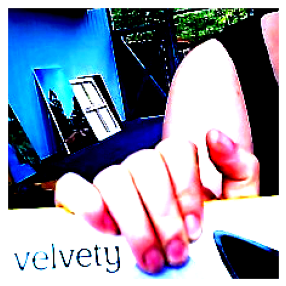

yeah


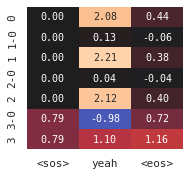

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


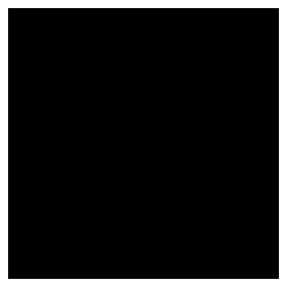

you know how to turn the phone


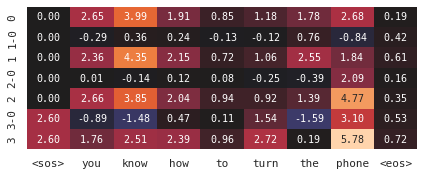

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


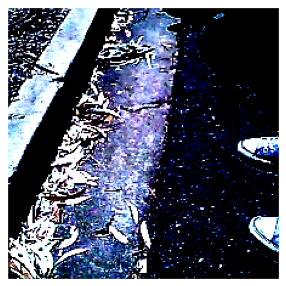

alright


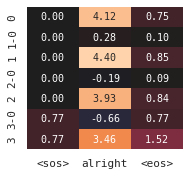

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


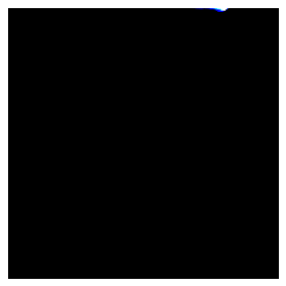

ok you want to wash it in the sink


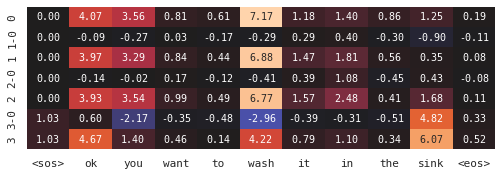

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


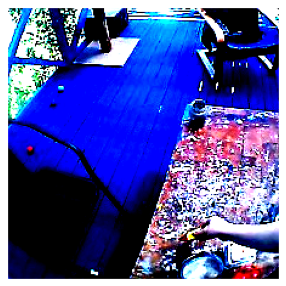

well we better wash your hands though


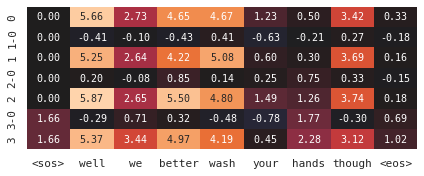

  0%|                                                                                                         | 0/65 [00:06<?, ?it/s]


In [10]:
def plot_loss_heatmap(losses, y_labels, annot=True, size=0.7):
    data = [losses[0]]
    yticklabels = ['0']
    for i in range(1, len(losses)):
        losses_i = losses[i]
        data.append([loss_i - loss_0 for loss_0, loss_i in zip(losses[0], losses_i)])
        yticklabels.append(f'{i}-0')
        data.append(losses_i)
        yticklabels.append(f'{i}')
    ax = sns.heatmap(data, center=0, annot=annot, fmt='.2f', xticklabels=y_labels, yticklabels=yticklabels, square=False, cbar=False)
    ax.figure.set_size_inches(size * (len(data[0]) + 1.), size * 0.5 * (len(data) + .5))
    plt.show()

dataloader = dataloader_fn()
example_i = 0
n_example = 5
for x, y, y_len, raw_y in tqdm(dataloader):
    for i in range(len(y)):
        plt.figure(figsize=(5, 5))
        plt.imshow(x[i].permute(1, 2, 0))
        plt.xticks([])
        plt.yticks([])
        plt.show()

        print(raw_y[i][0])

        y_ids = y[i][:y_len[i]]
        y_labels = [idx2word[y_id.item()] for y_id in y_ids]
        losses = [model_items[model_n].losses[example_i] for model_n in range(len(model_items))]
        plot_loss_heatmap(losses, y_labels)

        example_i += 1
        if example_i >= n_example:
            break

    if example_i >= n_example:
        break

cosine matrices:



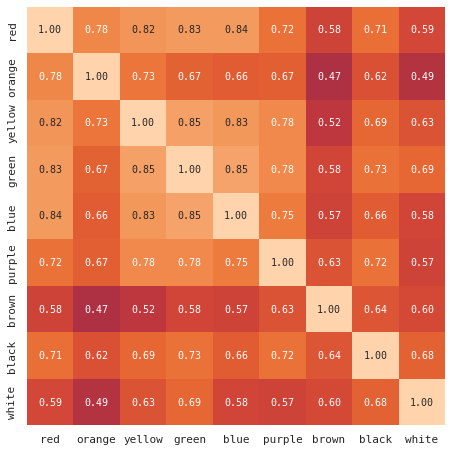

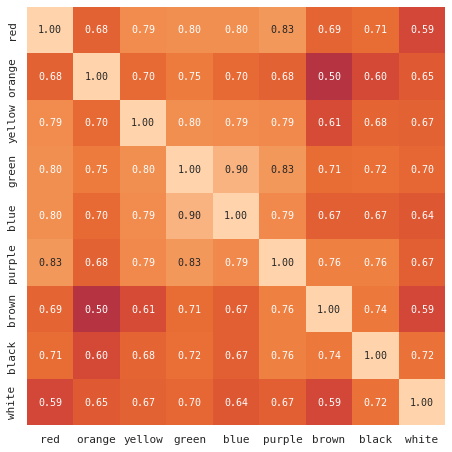

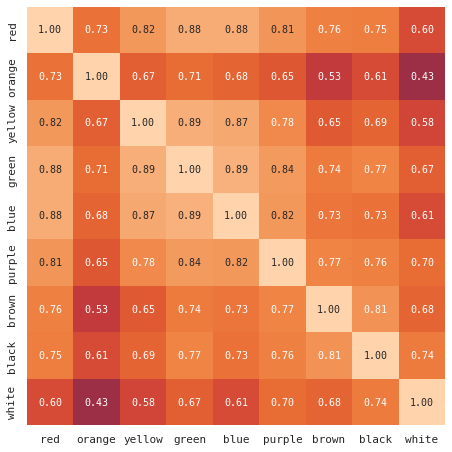

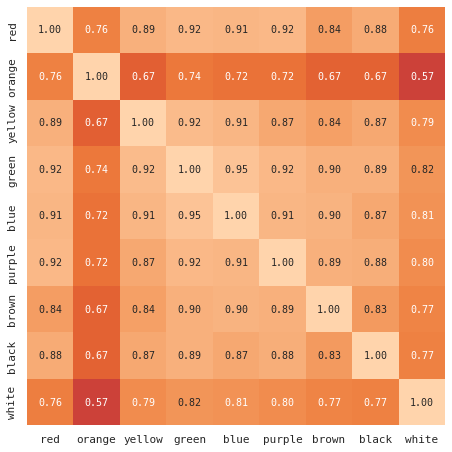

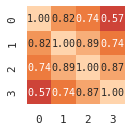

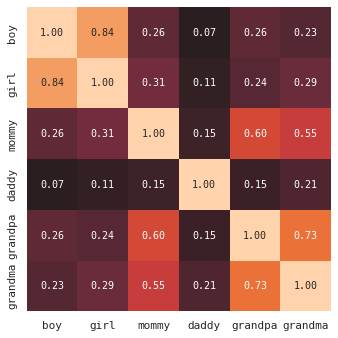

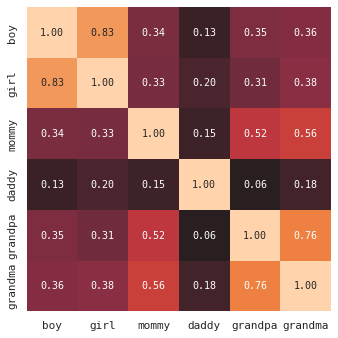

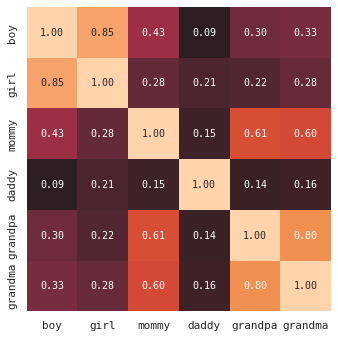

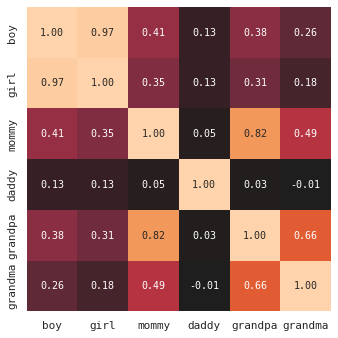

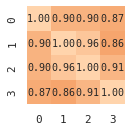

cosine matrices for the differentiations:



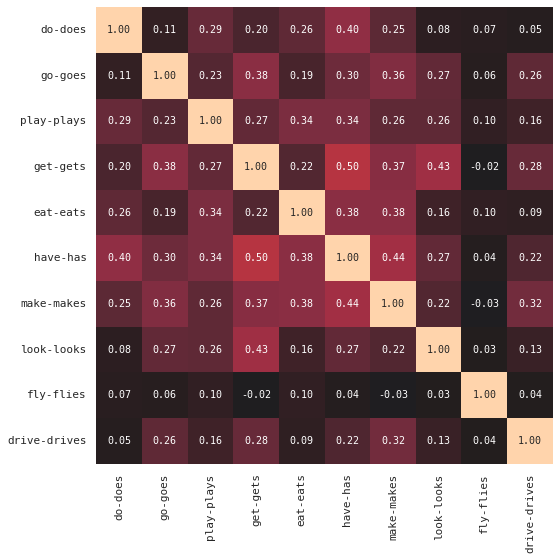

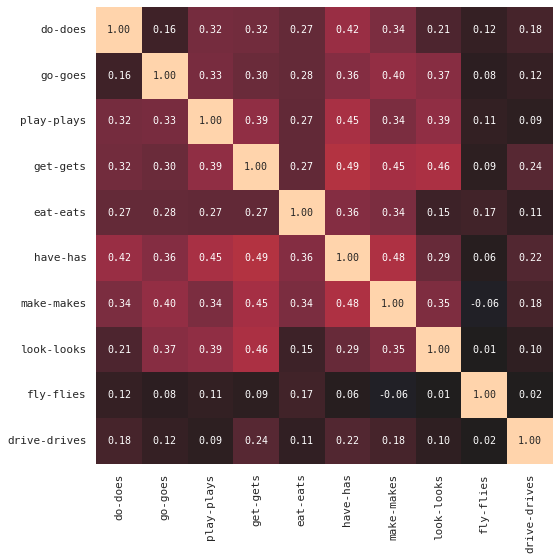

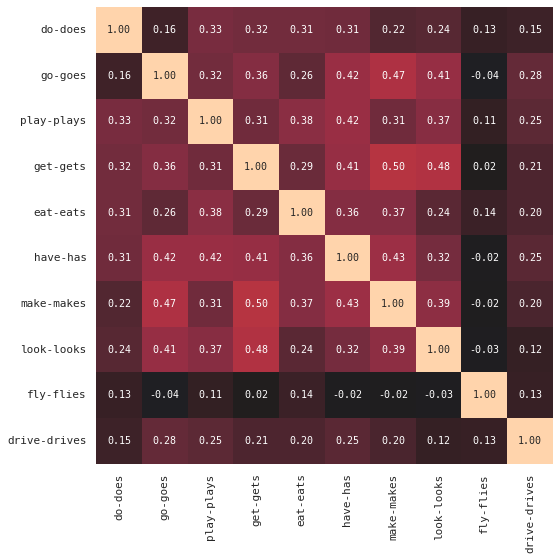

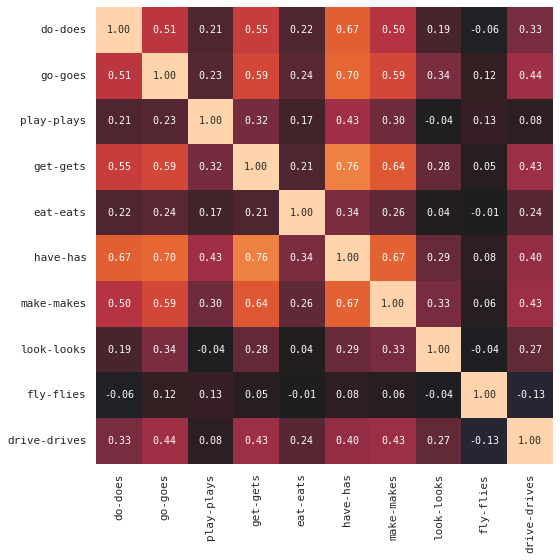

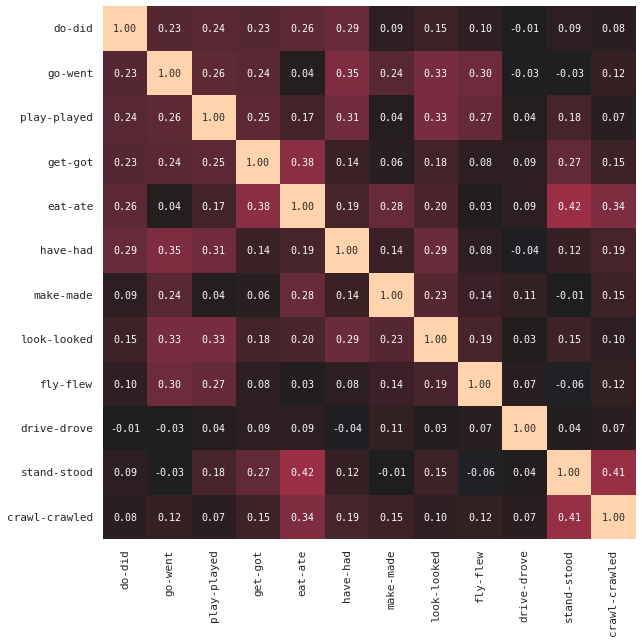

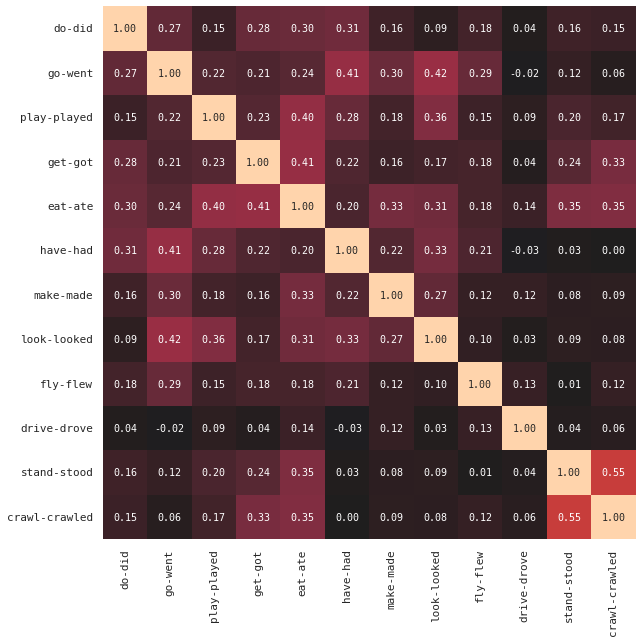

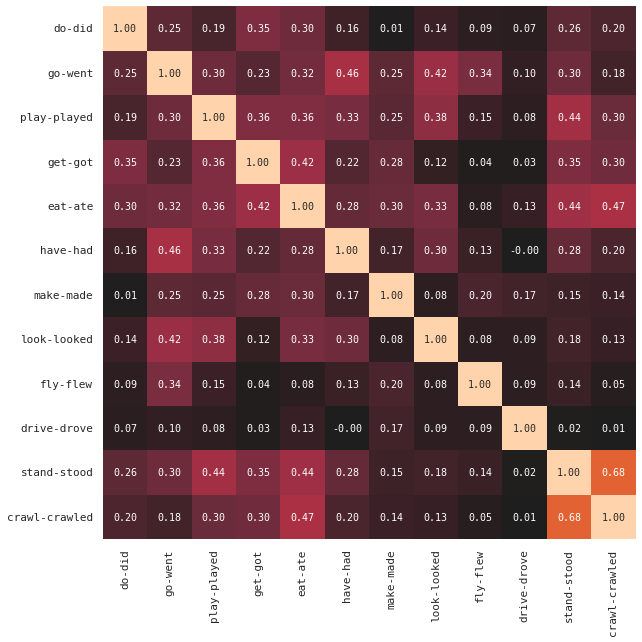

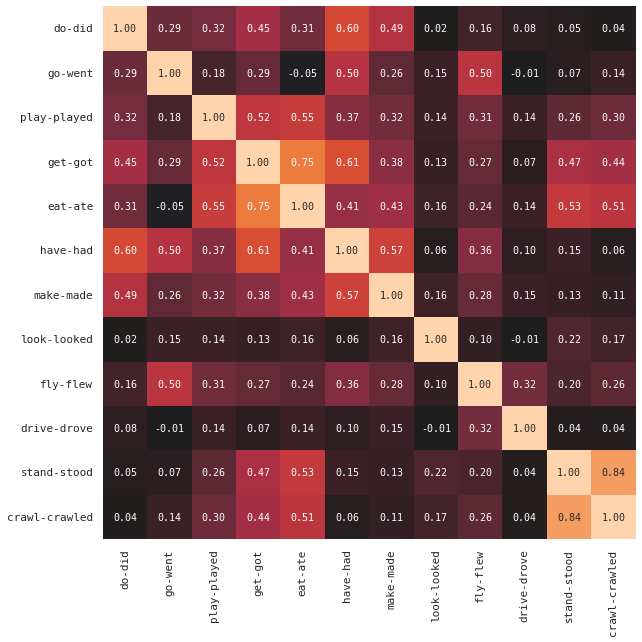

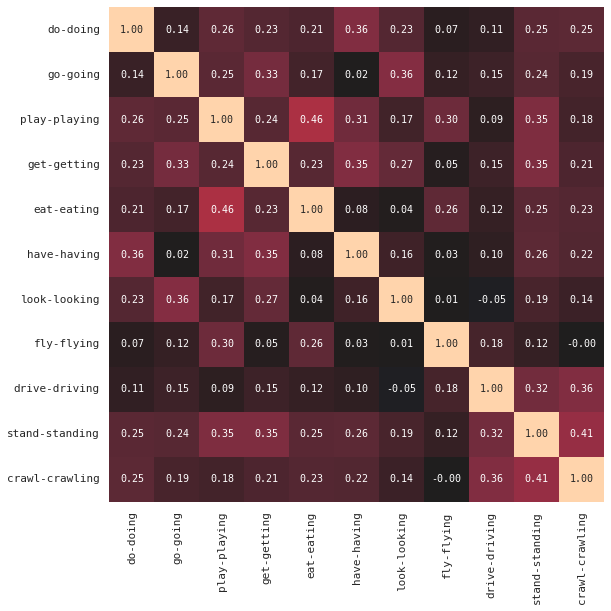

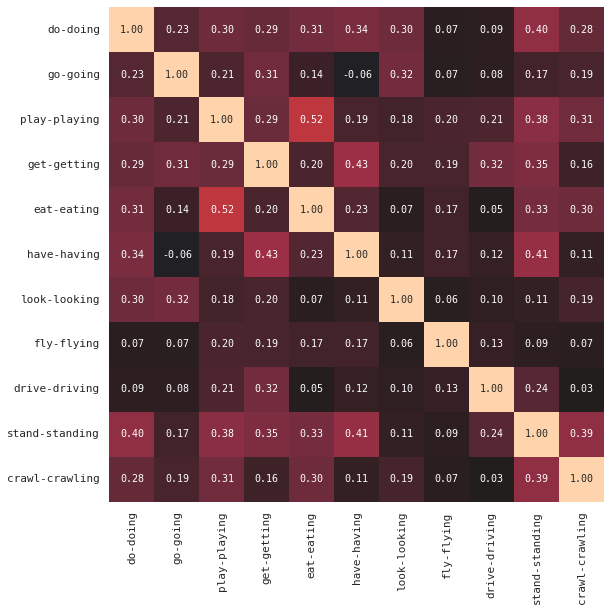

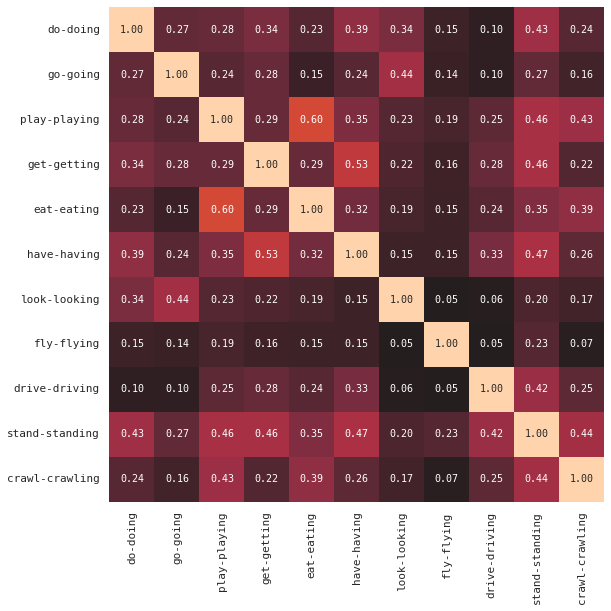

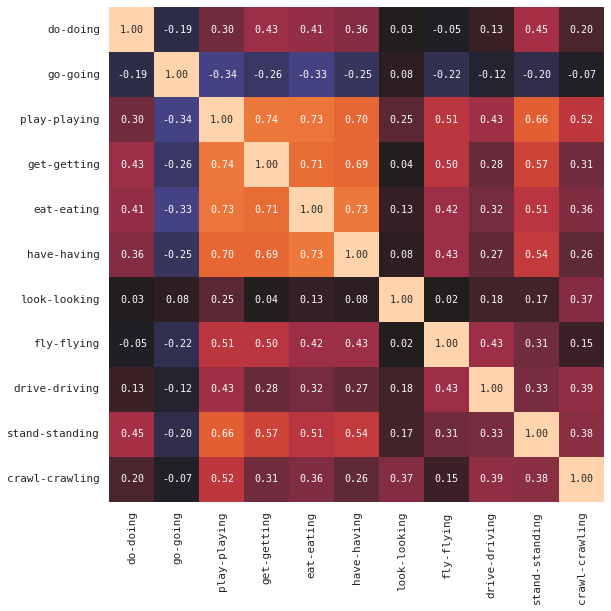

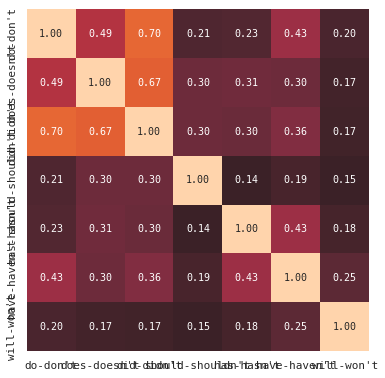

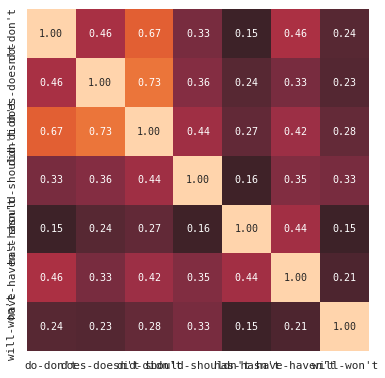

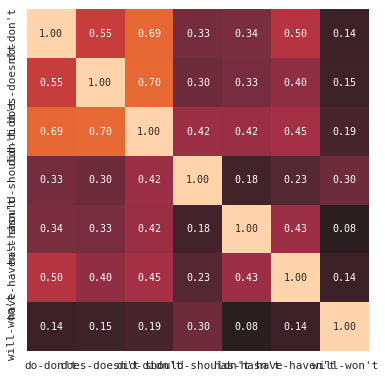

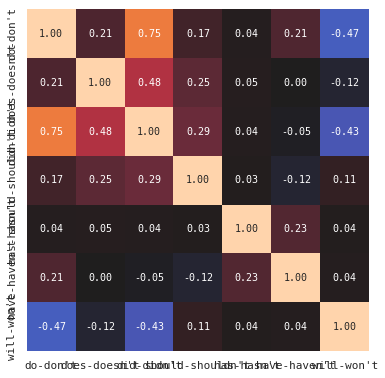

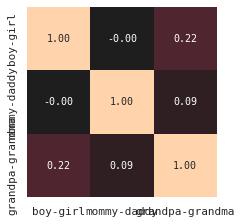

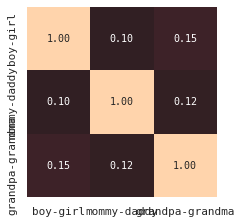

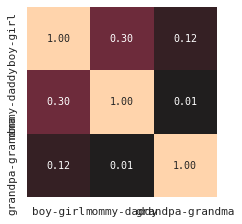

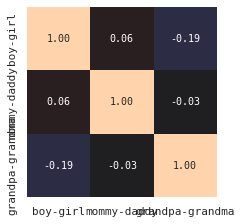

In [11]:
# cosine matrices for some tested words

from representation_similarity import *

np.set_printoptions(precision=2, suppress=True)

def split_tokens(inp):
    tokens = inp.split()
    token_ids = []
    for token in tokens:
        token_id = word2idx.get(token, UNK_TOKEN_ID)
        if token_id == UNK_TOKEN_ID:
            print(f'mapping {token} to UNK')
        token_ids.append(token_id)
    return token_ids

def get_vectors(token_ids, token_items, vector_attr='mean_vector'):
    return np.array([getattr(token_items[token_id_to_key[token_id]], vector_attr) for token_id in token_ids])

def plot_sim_heatmap(matrix, labels, annot=True, size=0.7):
    ax = sns.heatmap(matrix, vmin=-1, vmax=1, center=0, annot=annot, fmt='.2f', xticklabels=labels, yticklabels=labels, square=True, cbar=False)
    ax.figure.set_size_inches(size * (matrix.shape[0] + 2.), size * (matrix.shape[1] + 2.))
    plt.show()

def plot_vector_sim_heatmap(token_ids, vector_attr='mean_vector', **kwargs):
    tokens = [idx2word[token_id] for token_id in token_ids]
    vectors = []
    for model_n in range(len(models)):
        V = get_vectors(token_ids, model_items[model_n].token_items, vector_attr=vector_attr)
        vectors.append(V)
        plot_sim_heatmap(cosine_matrix(V), tokens, **kwargs)

    dissim_matrices = [cosine_dissim_matrix(V) for V in vectors]

    repres_sim_matrix = np.array([[rsa_of_dissim_matrices(A, B) for B in dissim_matrices] for A in dissim_matrices])
    plot_sim_heatmap(repres_sim_matrix, list(map(str, range(len(vectors)))), annot=True, size=.3)

def plot_diff_vector_sim_heatmap(token_ids, vector_attr='mean_vector', **kwargs):
    if len(token_ids) % 2 != 0:
        print('Error: number of tokens should be even.')
        return

    tokens = [idx2word[token_id] for token_id in token_ids]
    labels = [f'{tokens[i]}-{tokens[i+1]}' for i in range(0, len(tokens), 2)]

    for model_n in range(len(models)):
        V = get_vectors(token_ids, model_items[model_n].token_items, vector_attr=vector_attr)
        V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
        V = V[:, 1] - V[:, 0]
        plot_sim_heatmap(cosine_matrix(V), labels)

# cosine matrices
print('cosine matrices:')
print()
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    token_ids = split_tokens(inp)
    plot_vector_sim_heatmap(token_ids)

# cosine matrices for the differentiations (vector1 - vector0)
print('cosine matrices for the differentiations:')
print()
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    token_ids = split_tokens(inp)
    plot_diff_vector_sim_heatmap(token_ids)

number of nouns: 2820
number of verbs: 1123
<sos>      .     33155:     1.000     1.000     1.000    11.536
<eos>      .     32888:     1.740     1.740     1.798     9.727
you        PRP    8544:     5.401     5.219     5.394     3.737
the        DT     5735:     4.870     4.911     4.925     3.890
yeah       UH     4849:     9.275     9.663     9.932     7.674
a          DT     4467:     5.606     4.548     5.269     3.948
to         TO     4452:     2.140     1.939     2.113     2.859
and        CC     3761:     8.501     6.275     7.259    13.515
it         PRP    3467:     5.801     5.499     6.047     7.660
want       VBP    2775:     4.293     4.248     4.445     4.002
we         PRP    2757:    10.637     9.170     9.543     6.860
is         VBZ    2604:     4.530     4.194     4.889     9.210
i          PRP    2300:    23.738    22.605    23.755     5.850
that       DT     2016:    14.829    13.650    16.049    21.938
are        VBP    1962:     9.733     9.859    12.650    11.

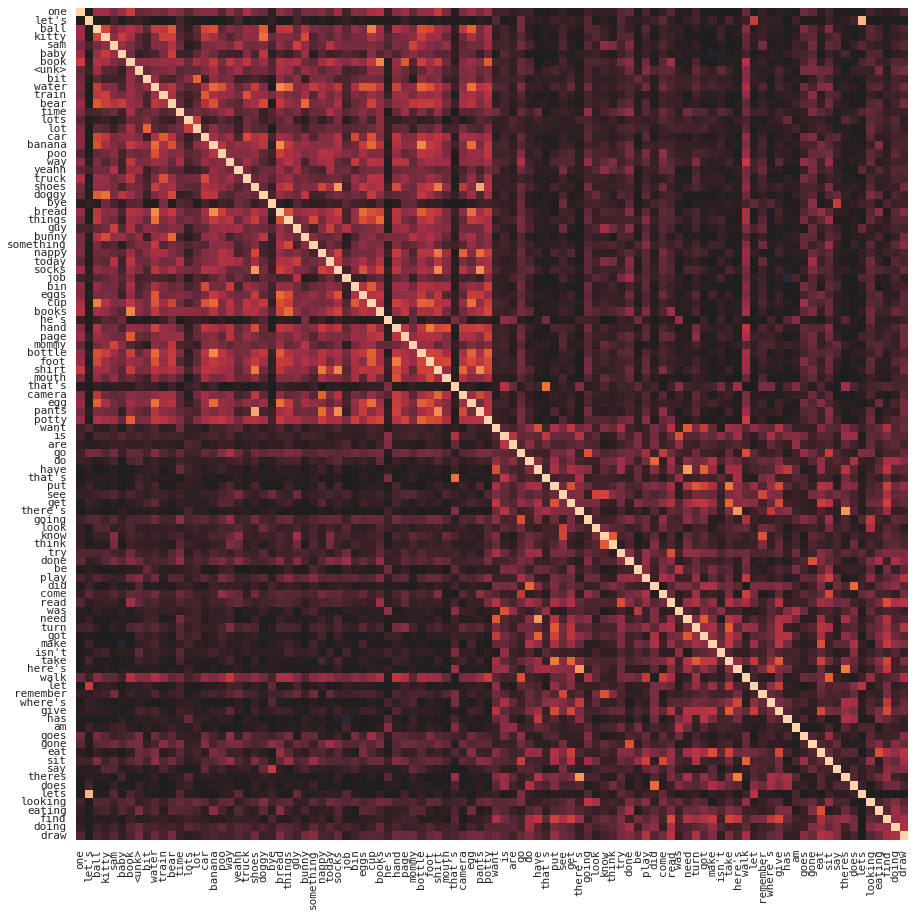

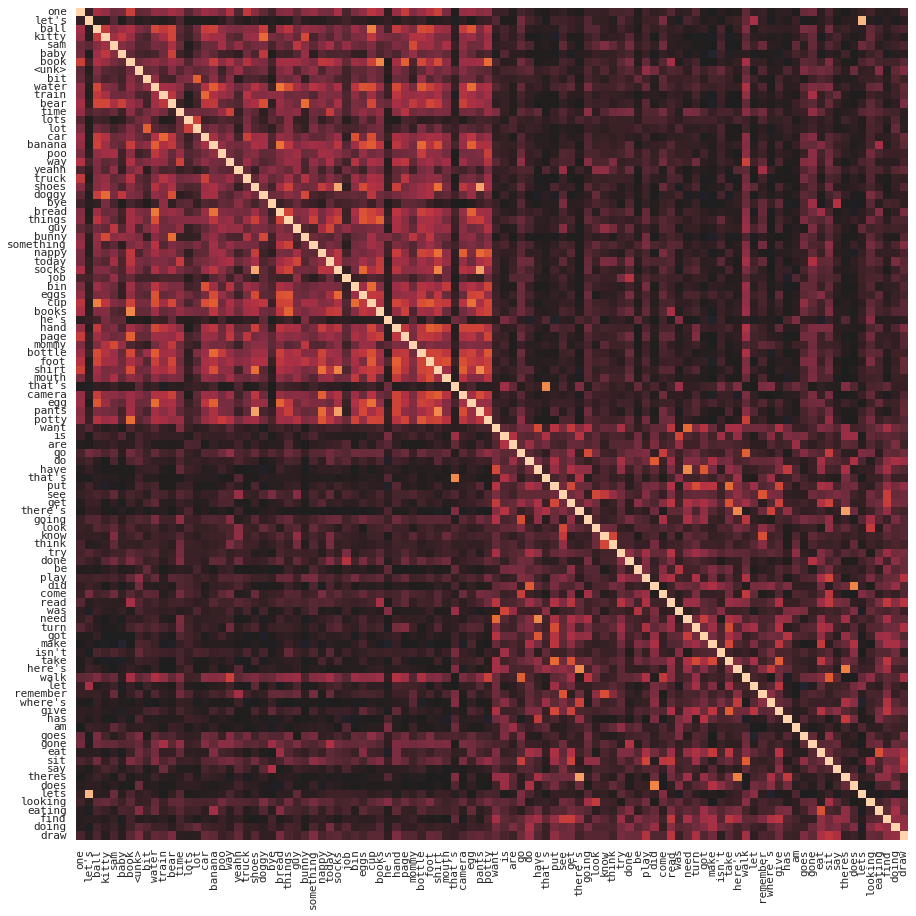

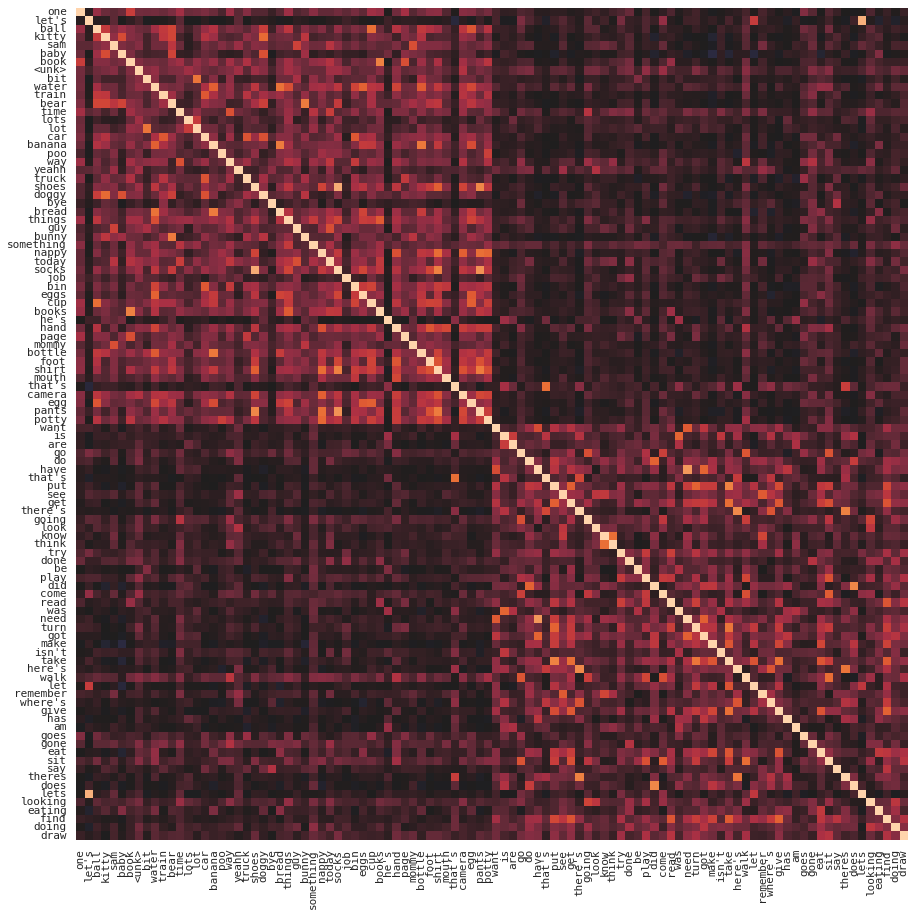

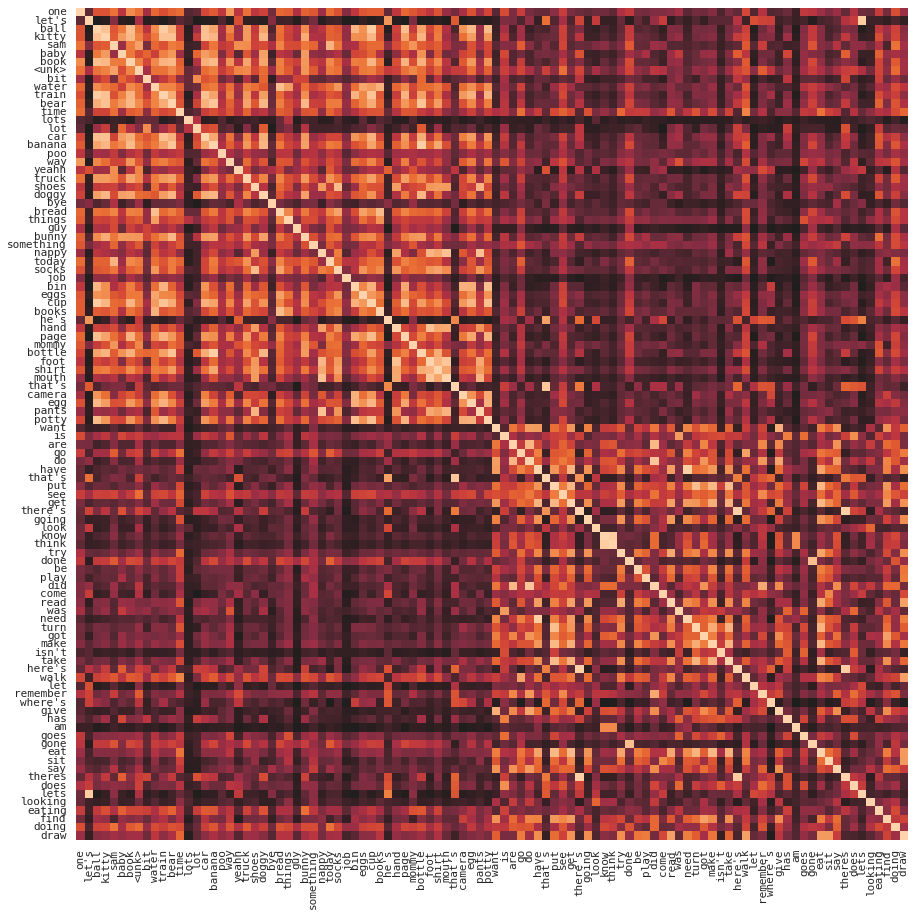

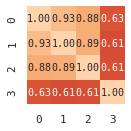

In [12]:
# select items; must not select items with cnt=0 which contain untrained vectors
list_token_items = list(token_items.items())
top_token_items = sorted(list_token_items, key=lambda item: item[1][0].cnt, reverse=True)
try:
    loss_diff_items = sorted(filter(lambda item: item[1][0].cnt > 5, list_token_items), key=item_cont_fn('loss diff')[0])[1:]
except:
    loss_diff_items = []
top_token_pos_items = sorted(list(token_pos_items.items()), key=lambda item: item[1][0].cnt, reverse=True)
top_noun_items = [item for item in top_token_items if item[0].pos.startswith('NN')]
print('number of nouns:', len(top_noun_items))
top_verb_items = [item for item in top_token_items if item[0].pos.startswith('VB')]
print('number of verbs:', len(top_verb_items))
top_noun_verb_items = []
for i in range(0, max(len(top_noun_items), len(top_verb_items)), 50):
    top_noun_verb_items += top_noun_items[i:i+50] + top_verb_items[i:i+50]

# check some items
for item in top_token_items[:100]:
    print(ppl_str(*item))
print()
for word in ['look', 'need', 'draw']:
    token_id = word2idx[word]
    key = token_id_to_key[token_id]
    print(ppl_str(key, token_items[key]))

plot_vector_sim_heatmap([item[0].token_id for item in top_noun_verb_items[:100]], annot=False, size=.15)

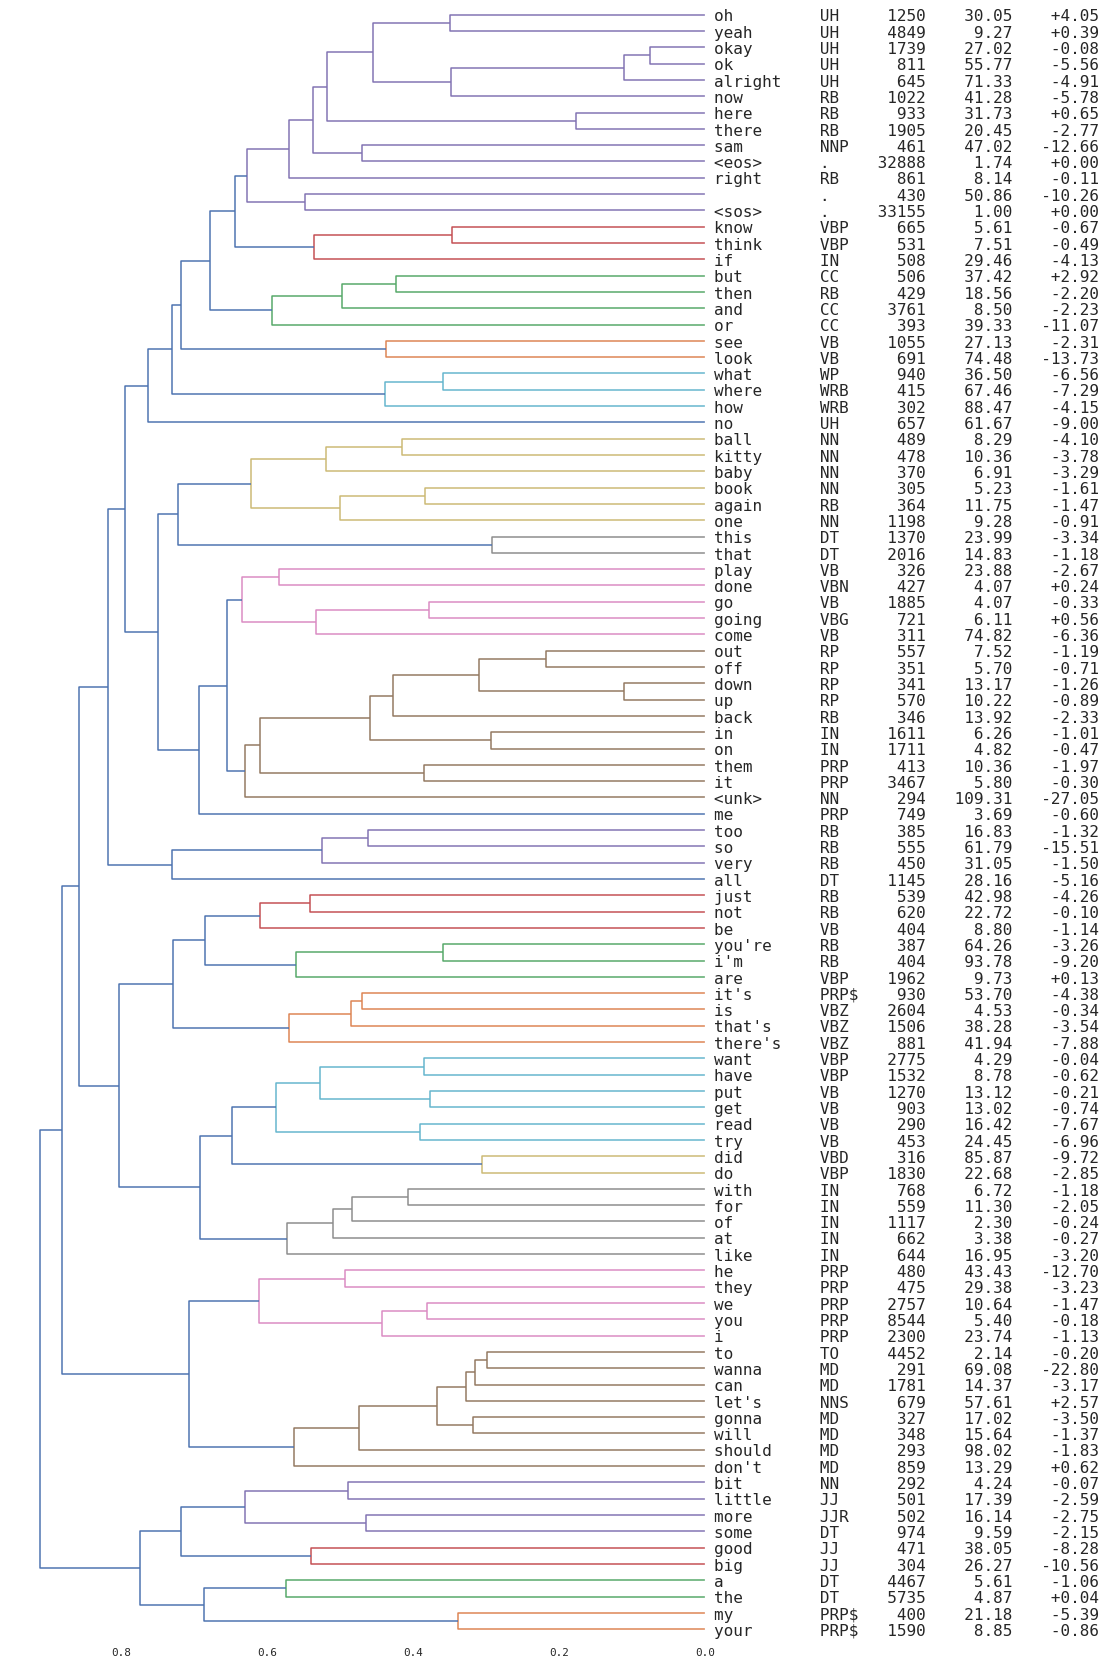

In [13]:
_ = plot_dendrogram(top_token_items[:100])

In [14]:
get_tsne_points([values[0] for key, values in top_token_items])

/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.


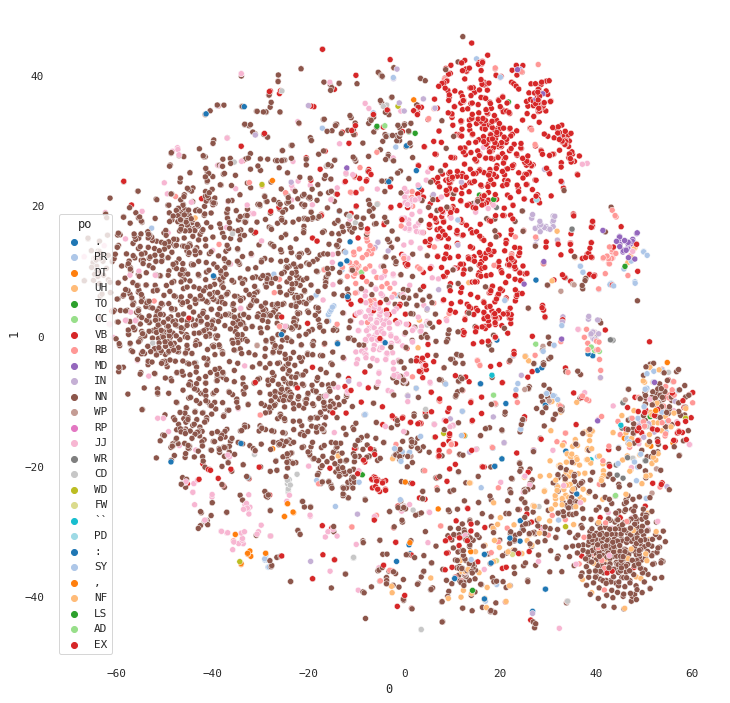

In [15]:
plot_tsne(top_token_items, ['po', conc_field, "AnimPhysical", "AnimMental", "Category", "AoA", "loss diff"][0], add_word=False)

ignored items sample: ':`` pb's:NNS marmithe:PRP pebe's:NNS pip:NN magpie:NN pu:NN hows:VBZ g:NNS aston:NNP georgia:NNP mr:NNP nana:NN breky:NN andre:NNP pb:NN lorry:NN natalie:NNP pebe:PRP typing:NN greatgrandma:NN ta:. t:NN whoo:UH mhmm:NNP pooed:VBD kookaburra:NN gummies:NNS emily:NNP hashbrowns:NNS mmmm:UH fiona:NNP nannie:NN er:UH s:VBZ jerry:NNP mee:NNP alex:NNP echidna:NN 4:CD 'bout:IN o:NN j:NN byebye:NNP pierre:NNP johnny:NN b:NN biccies:NNS rah:UH dan:NNP baa:NN bup:UH
plotting 148/200 = 74.00% items...


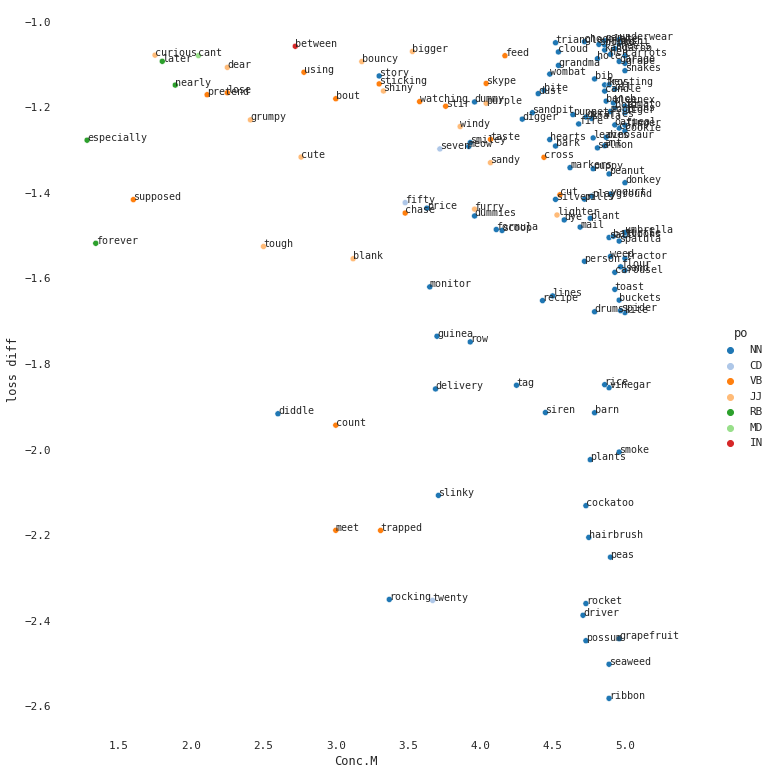

In [16]:
plot_xy([top_token_items, loss_diff_items[:200]][1], [conc_field, "AnimPhysical", "AoA"][0], ['loss', 'loss diff'][1], 'po', add_word=True)